# Transfer Learning with Tensorflow Part 3: Scaling up

We've seen the power of transfer learning featuter extraction and fine-tuning, now its time to scale up to all of the classes in Food101. (101 total classes of food)

Our goal is to beat the original Food101 paper.

Baseline: 50.67%

In [2]:
import tensorflow as tf
gpu = tf.config.list_physical_devices('GPU')
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Creating helper functions

In previous notebooks we've created series of helper functions but it is difficult to do that every single time so let's download them

In [4]:
def download_helper_functions():
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [5]:
#Download the helper function
import os
path = os.getcwd()
if not os.path.exists('/Users/klsharma22/Desktop/TensorflowCertifcationCourse/Transfer Learning/helper_functions.py'):
    download_helper_functions()

--2024-02-22 09:22:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-22 09:22:24 (91.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [6]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, make_confusion_matrix

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data

The data we're downlaoding comes from the original Food101 but was preprocessed

In [7]:
if not os.path.exists('/Users/klsharma22/Desktop/TensorflowCertifcationCourse/Transfer Learning/101_food_classes_10_percent.zip'):
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
    unzip_data('101_food_classes_10_percent.zip')

--2024-02-22 09:22:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.207, 74.125.202.207, 74.125.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  87.4MB/s    in 15s     

2024-02-22 09:22:47 (105 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [12]:
TRAIN_DIR = '101_food_classes_10_percent/train/'
TEST_DIR = '101_food_classes_10_percent/test/'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
LABEL_MODE = 'categorical'

In [13]:
# How many images classes are there
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/red_velvet_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/dumplings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/greek_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spaghetti_carbonara'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/paella'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/waffles'.
There are 0 directories and 250 images in '1

In [14]:
# Setup data inputs
import tensorflow as tf

train_data = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR, label_mode= LABEL_MODE, image_size= IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR, label_mode= LABEL_MODE, image_size= IMG_SIZE, shuffle= False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Steps we're going to take:
* Create a ModelCcheckpoint callback
* Create a data augmnetation layer to build data augmentation right into the model
* Build a headless Functional EfficientNetB0 backbone-model
* Comple our model
* Feature extract for 5 full passes (15% of test dataset which will be the validation dataset   )

In [9]:
# Create checkpoint callback
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only= True, monitor= "val_accuracy", save_best_only= True)

In [10]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    # preprocessing.Rescalinig(1/255.) required onlu if the data scaling is not present in the model
], name= 'data_augmentation_layer')

In [11]:
# Setup the base model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False)
base_model.trainable = False

# Setup model archtecture with trainable top layers
inputs = layers.Input(shape= IMG_SIZE + (3, ), name= "input_layer")
x = data_augmentation(inputs)
x = base_model(x, training= False) # put the base model n inference mode so the weights which need to stay frozen stay as it is
x = layers.GlobalAveragePooling2D(name= "global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation= "softmax", name= "output_layer")(x)

model = tf.keras.Model(inputs, outputs)


16705208/16705208 [==============================] - 0s 0us/step


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 3)     0         
 equential)                                                      
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [13]:
# Compiilng the model
model.compile(loss= 'categorical_crossentropy',
              optimizer= tf.keras.optimizers.legacy.Adam(),
              metrics= ['accuracy'])

In [14]:
with tf.device('/device:GPU:0'):
    history_10_percent = model.fit(train_data,
                                epochs= 5,
                                steps_per_epoch= len(train_data),
                                validation_data= test_data,
                                validation_steps= int(0.15 * len(test_data)))

Epoch 1/5
237/237 [==============================] - 160s 624ms/step - loss: 3.3800 - accuracy: 0.2697 - val_loss: 2.4449 - val_accuracy: 0.4624
Epoch 2/5
237/237 [==============================] - 112s 473ms/step - loss: 2.1916 - accuracy: 0.5003 - val_loss: 1.9722 - val_accuracy: 0.5254
Epoch 3/5
237/237 [==============================] - 89s 374ms/step - loss: 1.8137 - accuracy: 0.5686 - val_loss: 1.8421 - val_accuracy: 0.5358
Epoch 4/5
237/237 [==============================] - 86s 360ms/step - loss: 1.6169 - accuracy: 0.6055 - val_loss: 1.7771 - val_accuracy: 0.5376
Epoch 5/5
237/237 [==============================] - 79s 334ms/step - loss: 1.4488 - accuracy: 0.6466 - val_loss: 1.7018 - val_accuracy: 0.5458


In [15]:
model.evaluate(test_data)

790/790 [==============================] - 59s 74ms/step - loss: 1.5840 - accuracy: 0.5811


[1.5839896202087402, 0.58106929063797]

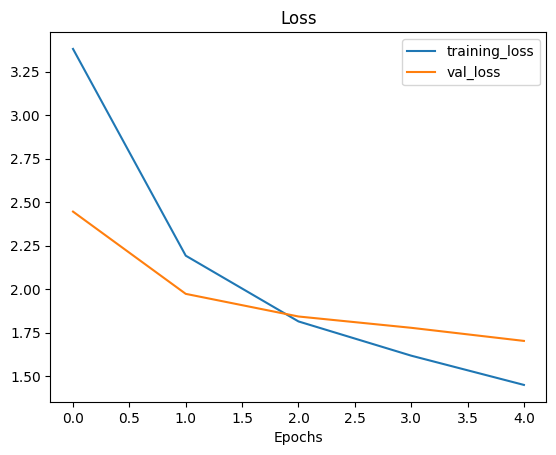

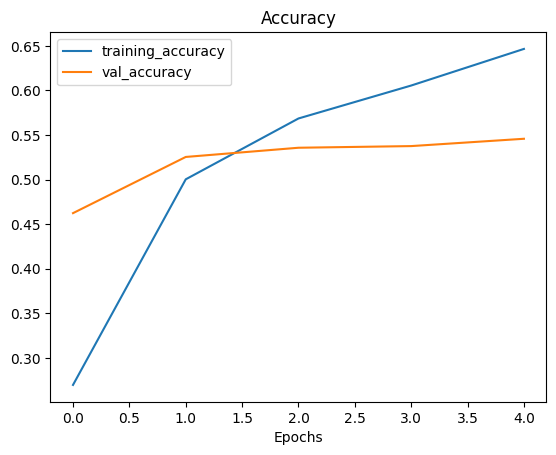

In [16]:
plot_loss_curves(history_10_percent)

> Accordinig to the history, the model is not learning in the correct manner so we need to fine-tune the model. The model is over-fitting

## Fine-tuning

In [17]:
# Unfreeze all of the layers iin the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable= False

In [18]:
# Recompile the model using lower learning rate
model.compile(loss= 'categorical_crossentropy',
              optimizer= tf.keras.optimizers.legacy.Adam(learning_rate= 0.0001),
              metrics= ['accuracy'])

In [19]:
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_augmentation_layer True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [20]:
for i, layer in enumerate(model.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [21]:
fine_tune_epochs = 10

In [23]:
tf.random.set_seed(42)
tf.config.set_soft_device_placement(True)
with tf.device('/device:GPU:0'):
    history_10_percent_fine_tune = model.fit(train_data,
            epochs= fine_tune_epochs,
            validation_data= test_data,
            validation_steps= int(0.15 * len(test_data)),
            initial_epoch= 5)

Epoch 6/10
237/237 [==============================] - 81s 313ms/step - loss: 1.2131 - accuracy: 0.6861 - val_loss: 1.7156 - val_accuracy: 0.5440
Epoch 7/10
237/237 [==============================] - 69s 287ms/step - loss: 1.0957 - accuracy: 0.7081 - val_loss: 1.6862 - val_accuracy: 0.5559
Epoch 8/10
237/237 [==============================] - 63s 266ms/step - loss: 1.0154 - accuracy: 0.7265 - val_loss: 1.6985 - val_accuracy: 0.5551
Epoch 9/10
237/237 [==============================] - 58s 241ms/step - loss: 0.9540 - accuracy: 0.7424 - val_loss: 1.6734 - val_accuracy: 0.5591
Epoch 10/10
237/237 [==============================] - 56s 237ms/step - loss: 0.9018 - accuracy: 0.7583 - val_loss: 1.6532 - val_accuracy: 0.5630


In [24]:
model.evaluate(test_data)

790/790 [==============================] - 54s 68ms/step - loss: 1.4808 - accuracy: 0.6063


[1.4807939529418945, 0.6062970161437988]

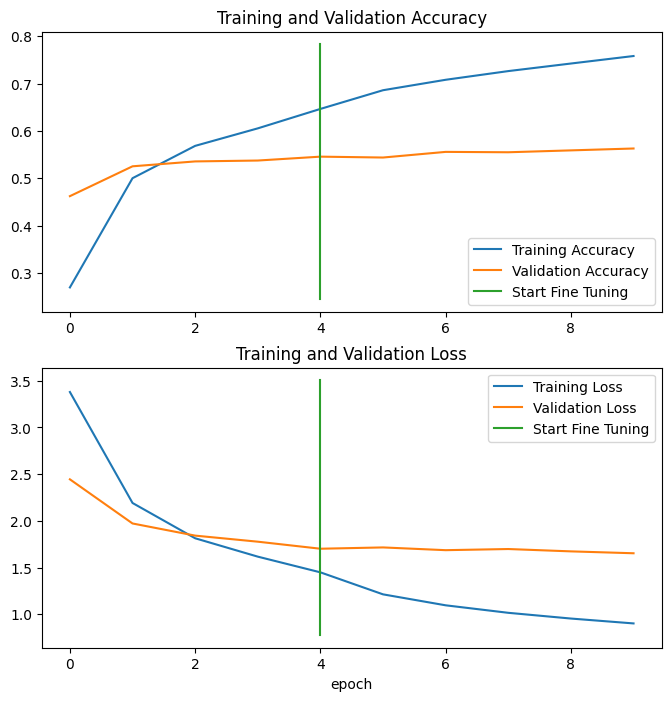

In [25]:
compare_historys(original_history= history_10_percent,
                 new_history= history_10_percent_fine_tune)

## Save and load our model

To use our model in external application, we'll need to save it and export it somwewhere

In [26]:
# Save our model
model.save("model/101_food_classes_10_percent_all_data")

In [27]:
# Load model
load_model = tf.keras.models.load_model("model/101_food_classes_10_percent_all_data")

In [28]:
# Evaluate loaded model and compare performance to pre saved model
loaded_result = load_model.evaluate(test_data)
loaded_result

790/790 [==============================] - 58s 71ms/step - loss: 1.4808 - accuracy: 0.6063


[1.4807939529418945, 0.6062970161437988]

In [29]:
all_classes_fine_tune_result = model.evaluate(test_data)

790/790 [==============================] - 54s 68ms/step - loss: 1.4808 - accuracy: 0.6063


## Evaluating performance of the model across all different classes

Let's make some prediction, visulize and then later find out which predictions were whic predictions wer the most wrong

In [8]:
# Downloading pre trained model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-02-22 09:23:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.207, 173.194.194.207, 173.194.196.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   129MB/s    in 0.3s    

2024-02-22 09:23:05 (129 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [9]:
unzip_data('/content/06_101_food_class_10_percent_saved_big_dog_model.zip')

In [10]:
model = tf.keras.models.load_model('/content/06_101_food_class_10_percent_saved_big_dog_model')

In [ ]:
# Evaluate loaded model
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

 48/790 [>.............................] - ETA: 27:22 - loss: 2.2890 - accuracy: 0.5150

## Making predictions with our trained model

In [ ]:
# Make predictions with model
preds_prob = model.predict(test_data, verbose= 1) # setting verbose as 1 to see how much time it is going to take

In [ ]:
len(test_data)

In [ ]:
790 * 32

In [ ]:
# How many predictions are there
len(preds_prob)

In [ ]:
# Shape of predictions
preds_prob.shape

In [ ]:
# Let's see first 10 predictions
preds_prob[:10]

In [ ]:
len(preds_prob[0])

In [ ]:
for pred_class in tf.argmax(preds_prob, axis= 1)[:10]:
  print(train_data.class_names[pred_class])

In [ ]:
pred_classes = tf.argmax(preds_prob, axis= 1)

Now we've got a prediction array for all our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [ ]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

## Evaluating our model's predictions

One way to check our model's prediction array is in the smae order as our test labels array is to find the accuracy score

In [ ]:
# Let's try scikit learn accuracy score
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true= y_labels,
                          y_pred= pred_classes)

accuracy

## Make Confusion Matrix

In [ ]:
make_confusion_matrix(y_true= y_labels,
                      y_pred= pred_classes,
                      classes= test_data.class_names)